# Explaining the Titanic Dataset with Partial Dependence Explanations

In this tutorial, we will use our **Partial Dependence Explainer** to explain the Titanic dataset. The same dataset and model used in `basic_explanation_generation.ipynb` are reused here. The difference is the explanation algorithm and the generated explanation.


### In this tutorial, you will learn...
1. How to use basic Pyreal to generate Partial Dependence Explanation for your ML model


Data source:
Kaggle. (2012). Titanic: Machine Learning from Disaster. Retrieved from https://www.kaggle.com/c/titanic/data.


## Data Preparation (same as other tutorials)

We will begin by loading the data, and writing out human-readable descriptions of all features. These descriptions will be used later to make the explanations provided more useful.

Our input data includes 11 features, each referring to one passenger who was on board the Titanic. The target variable we seek to predict is whether each passenger survived or not.

In [1]:
from sklearn.model_selection import train_test_split
from pyreal.sample_applications import titanic
import numpy as np

np.random.seed(1)

x_orig, y = titanic.load_data(include_targets=True)

x_train_orig, x_test_orig, y_train, y_test = train_test_split(x_orig, y, test_size=.20)

feature_descriptions = {
    "PassengerId": "Passenger ID",
    "Pclass": "Ticket Class",
    "SibSp": "Number of siblings/spouses aboard",
    "Parch": "Number of parents/children aboard",
    "Ticket": "Ticket Number",
    "Fare": "Passenger Fare",
    "Cabin": "Cabin Number",
    "Embarked": "Port of Embarkment",
}

x_train_orig.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
301,302,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
309,310,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C
516,517,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S
120,121,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
570,571,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S


Next, we load the transfomers.

In [2]:
from pyreal.transformers import OneHotEncoder, ColumnDropTransformer, MultiTypeImputer
from pyreal.transformers import fit_transformers, run_transformers

column_drop = ColumnDropTransformer(["PassengerId", "Name", "Ticket", "Cabin"])
imputer = MultiTypeImputer()
one_hot_encoder = OneHotEncoder(["Sex", "Embarked"],)

transformers = [column_drop, imputer, one_hot_encoder]
x_transform_train = fit_transformers(transformers, x_train_orig)
x_transform_test = run_transformers(transformers, x_test_orig)

Now that we have our transformed data, we can train an ML model. Pyreal currently accepts models as objects with `.predict()` functions or filenames containing such objects in pickled format.

In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(x_transform_train, y_train)

preds = model.predict(x_transform_test)
print("Test accuracy: %.2f" % (np.mean(preds==y_test)*100))

Test accuracy: 79.89


Now, we can initialize the PartialDependenceExplainer Explainer object. The explainer accepts one or two features as arguments.

In [4]:
from pyreal.explainers import PartialDependenceExplainer

# TODO: support for transformers that modify feature names is not complete
explainer = PartialDependenceExplainer(model, 
                                       features=["Fare", "Pclass"],
                                       x_train_orig=x_train_orig, 
                                       transformers=transformers,
                                       feature_descriptions=feature_descriptions,
                                       fit_on_init=True
                                       )

Finally, we can visualize the partial dependence of the selected features with the `partial_dependence_plot()` function.

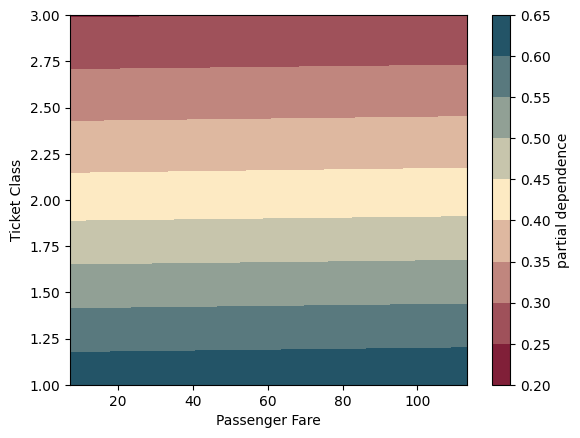

In [5]:
from pyreal.visualize import partial_dependence_plot
pdp = explainer.produce()
partial_dependence_plot(pdp, show=True)